# Titanic - ML from disaster

Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(13)

In [2]:
titanic = pd.read_csv("titanic.csv")
df = titanic.drop(['Name', 'Ticket', 'Cabin','PassengerId'], axis=1)


In [3]:
# Split data 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=13)

In [4]:
# Review shape of training data
train.shape

(916, 8)

In [5]:
# Review shape of test data
test.shape

(393, 8)

In [6]:
# Set target variable and remove target from input data.

train_y = train[['Survived']]
test_y = test[['Survived']]

train_inputs = train.drop(['Survived'], axis=1)
test_inputs = test.drop(['Survived'], axis=1)

In [7]:
test_inputs.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
308,2,male,30.0,1,0,24.00,C
714,2,male,52.0,0,0,13.00,S
1269,1,male,55.0,0,0,50.00,S
979,3,female,30.0,0,0,7.75,Q
1080,2,male,40.0,0,0,13.00,S


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

In [9]:
# Reveiw training dataset
train_inputs.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
624,3,male,21.00,0,0,16.10,S
676,3,male,24.50,0,0,8.05,S
1141,2,female,0.92,1,2,27.75,S
795,2,male,39.00,0,0,13.00,S
1177,3,male,30.00,0,0,7.25,S


In [10]:
# Review column types
train_inputs.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [11]:
train_inputs['Pclass']=train_inputs['Pclass'].astype('object')

In [12]:
train_inputs.dtypes

Pclass       object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [13]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [14]:
# Confirm numeric cols
numeric_columns

['Age', 'SibSp', 'Parch', 'Fare']

In [15]:
# Confirm cat cols
categorical_columns

['Pclass', 'Sex', 'Embarked']

In [16]:
# Create numeric pipeline
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())])

In [17]:
# Create cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
# Create preprocessor
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)],
        remainder='drop')

In [19]:
# #Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)
train_x.shape

(916, 13)

In [20]:
#Fit and transform the test data
test_x = preprocessor.transform(test_inputs)

test_x.shape

(393, 13)

In [21]:
train_y

,Survived
624,0
676,0
1141,1
795,0
1177,0
...,...
866,1
742,1
74,1
176,0


In [22]:
# Determine a baseline accuracy using most frequent stra

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

In [23]:
# Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_y, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.62882096069869


In [24]:
# Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_y, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.6081424936386769


## Create NN Model

In [25]:
# Create a single layer neural network model
import tensorflow as tf
from tensorflow import keras

np.random.seed(13)
tf.random.set_seed(13)

NN = keras.models.Sequential()

NN.add(keras.layers.Input(shape=(train_x.shape[1],)))
NN.add(keras.layers.Dense(16, activation='relu'))
NN.add(keras.layers.Dense(1, activation='sigmoid'))

In [26]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

NN.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [27]:
# Fit the model
history = NN.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=100)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6242 - loss: 0.6512 - val_accuracy: 0.7583 - val_loss: 0.5122
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8043 - loss: 0.4708 - val_accuracy: 0.8193 - val_loss: 0.4522
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8682 - loss: 0.4046 - val_accuracy: 0.8397 - val_loss: 0.4140
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8624 - loss: 0.3731 - val_accuracy: 0.8372 - val_loss: 0.4077
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.3687 - val_accuracy: 0.8372 - val_loss: 0.4042
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8636 - loss: 0.3668 - val_accuracy: 0.8422 - val_loss: 0.3958
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8629 - loss: 0.3609 - val_accuracy: 0.8448 - val_loss: 0.3892
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.3566 - val_accuracy: 0.8422 - val_loss

In [28]:
train_scores = NN.evaluate(train_x, train_y, verbose=0)

print(f"Train {NN.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {NN.metrics_names[1]}: {train_scores[1]*100:.2f}%")

Train loss: 0.33
Train compile_metrics: 87.55%


In [29]:
test_scores = NN.evaluate(test_x, test_y, verbose=0)

print(f"Test {NN.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {NN.metrics_names[1]}: {test_scores[1]*100:.2f}%")

Test loss: 0.38
Test compile_metrics: 84.73%


In [30]:
# Create a multi-layer Deep Neural Network model

np.random.seed(13)
tf.random.set_seed(13)

DNN = keras.models.Sequential()

DNN.add(keras.layers.Input(shape=(train_x.shape[1],)))
DNN.add(keras.layers.Dense(16, activation='relu'))
DNN.add(keras.layers.Dense(12, activation='relu'))
DNN.add(keras.layers.Dense(8, activation='relu'))
DNN.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
# Compile model
adam = keras.optimizers.Adam(learning_rate=0.001)
DNN.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [32]:
# Apply early stopping to prevent overfitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=3, verbose=1)

callback = [earlystop]

DNN.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=100, batch_size=100, callbacks=callback)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4678 - loss: 0.7008 - val_accuracy: 0.4885 - val_loss: 0.6931
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5351 - loss: 0.6822 - val_accuracy: 0.5878 - val_loss: 0.6810
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6031 - loss: 0.6669 - val_accuracy: 0.6310 - val_loss: 0.6676
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6589 - loss: 0.6512 - val_accuracy: 0.6641 - val_loss: 0.6537
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6976 - loss: 0.6353 - val_accuracy: 0.6667 - val_loss: 0.6388
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7121 - loss: 0.6188 - val_accuracy: 0.6692 - val_loss: 0.6222
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7146 - loss: 0.6010 - val_accuracy: 0.6845 - val_loss: 0.6040
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7220 - loss: 0.5817 - val_accuracy: 0.6819 - 

In [33]:
train_scores = DNN.evaluate(train_x, train_y, verbose=0)

print(f"Train {DNN.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {DNN.metrics_names[1]}: {train_scores[1]*100:.2f}%")

Train loss: 0.32
Train compile_metrics: 88.54%


In [34]:
test_scores = DNN.evaluate(test_x, test_y, verbose=0)

print(f"Test {DNN.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {DNN.metrics_names[1]}: {test_scores[1]*100:.2f}%")

Test loss: 0.38
Test compile_metrics: 83.97%


## Random Forest Model with Feature Importance Chart

In [35]:
train_x2 = pd.DataFrame(train_x, columns=preprocessor.get_feature_names_out())

D:\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 1) cat__Sex_female                0.389280
 2) cat__Sex_male                  0.303544
 3) num__Fare                      0.096480
 4) num__Age                       0.069867
 5) num__SibSp                     0.033004
 6) cat__Pclass_3                  0.030601
 7) num__Parch                     0.026466
 8) cat__Pclass_1                  0.019615
 9) cat__Embarked_S                0.012255
10) cat__Pclass_2                  0.007167
11) cat__Embarked_C                0.006759
12) cat__Embarked_Q                0.004955
13) cat__Embarked_unknown          0.000008


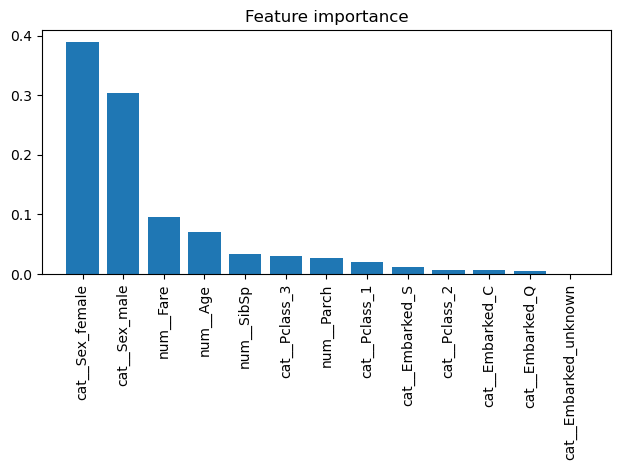

In [36]:
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt

feat_labels = train_x2.columns

rnd_clf = RandomForestClassifier(n_estimators=73, max_depth=6, min_samples_split=3, n_jobs=-1) 

rnd_clf.fit(train_x2, train_y)

importances = rnd_clf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(train_x2.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(train_x2.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(train_x2.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, train_x2.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

In [37]:
train_y_pred = rnd_clf.predict(train_x)
train_acc = accuracy_score(train_y, train_y_pred)
print('Train acc: {}' .format(train_acc))

test_y_pred = rnd_clf.predict(test_x)
test_acc = accuracy_score(test_y, test_y_pred)
print('Test acc: {}' .format(test_acc))

Train acc: 0.8864628820960698
Test acc: 0.8575063613231552


D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Try ExtraTrees Classifier model

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

ETC = ExtraTreesClassifier(n_estimators=50, max_depth=8, min_samples_split=3, n_jobs=-1)

ETC.fit(train_x, train_y)

D:\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesClassifier(max_depth=8, min_samples_split=3, n_estimators=50,
                     n_jobs=-1)

In [39]:
train_y_pred = ETC.predict(train_x)
train_acc = accuracy_score(train_y, train_y_pred)
print('Train acc: {}' .format(train_acc))

test_y_pred = ETC.predict(test_x)
test_acc = accuracy_score(test_y, test_y_pred)
print('Test acc: {}' .format(test_acc))

Train acc: 0.8995633187772926
Test acc: 0.8473282442748091


## Let's plot feature importance

D:\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 1) cat__Sex_male                  0.411702
 2) cat__Sex_female                0.330718
 3) num__Fare                      0.043156
 4) cat__Pclass_1                  0.039566
 5) num__Age                       0.039296
 6) num__Parch                     0.032314
 7) cat__Pclass_3                  0.031439
 8) num__SibSp                     0.030430
 9) cat__Embarked_S                0.015384
10) cat__Pclass_2                  0.010636
11) cat__Embarked_C                0.008758
12) cat__Embarked_Q                0.006459
13) cat__Embarked_unknown          0.000141


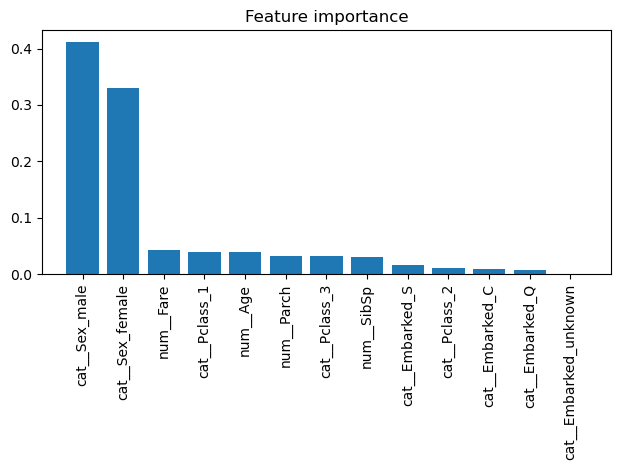

In [40]:
import matplotlib.pyplot as plt

feat_labels = train_x2.columns

ETC = ExtraTreesClassifier(n_estimators=50, max_depth=8, min_samples_split=3, n_jobs=-1)

ETC.fit(train_x2, train_y)

importances = ETC.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(train_x2.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(train_x2.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(train_x2.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, train_x2.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

# KNN Model with Features/Model Accuracy Chart

### First, create Sequential feature selection algorithms

In [41]:
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        train_x, test_x, train_y, test_y = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = train_x.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(train_x, train_y, 
                                 test_x, test_y, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(train_x, train_y, 
                                         test_x, test_y, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, train_x, train_y, test_x, test_y, indices):
        self.estimator.fit(train_x[:, indices], train_y)
        y_pred = self.estimator.predict(test_x[:, indices])
        score = self.scoring(test_y, y_pred)
        return score

D:\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self

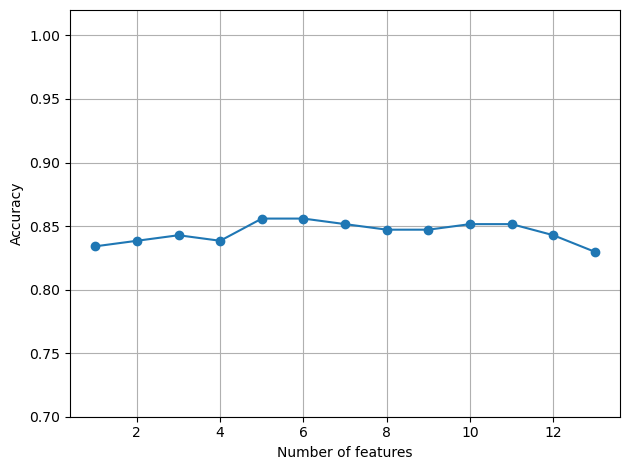

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(train_x, train_y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/04_09.png', dpi=300)
plt.show()

# Alternate Scalers in the pipeline

In [43]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

# Create numeric pipeline with MaxAbsScaler
numeric_transformerABS = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', MaxAbsScaler())])

# Create numeric pipeline RobustScaler
numeric_transformerRBST = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', RobustScaler())])

# Create ABS preprocessor
preprocessorABS = ColumnTransformer([
        ('num', numeric_transformerABS, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)],
        remainder='drop')

# Create RBST preprocessor
preprocessorRBST = ColumnTransformer([
        ('num', numeric_transformerRBST, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)],
        remainder='drop')

In [44]:
# Fit and transform the train and test data with Standard Scaler
train_x = preprocessor.fit_transform(train_inputs)
test_x = preprocessor.transform(test_inputs)

# Fit and transform the train data Robust Scaler
train_xRBST = preprocessorRBST.fit_transform(train_inputs)
test_xRBST = preprocessorRBST.transform(test_inputs)

# Fit and transform the train data with Max Absolute Scaler
train_xABS = preprocessorABS.fit_transform(train_inputs)
test_xABS = preprocessorABS.transform(test_inputs)

# SVC Model 

In [45]:
from sklearn.svm import SVC

LSVC = SVC(kernel="linear")
LSVC2 = SVC(kernel="linear")
LSVC3 = SVC(kernel="linear")

LSVC.fit (train_x, train_y)
LSVC2.fit (train_xABS, train_y)
LSVC3.fit (train_xRBST, train_y)

D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [46]:
train_x

array([[-7.03674414e-01, -4.78505738e-01, -4.56112058e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.30117491e-01, -4.78505738e-01, -4.56112058e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.27310956e+00,  4.64099114e-01,  1.76032638e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.56075914e-01, -4.78505738e-01, -4.56112058e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.42327405e-04,  2.34930882e+00,  6.52107159e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.17214448e+00, -4.78505738e-01, -4.56112058e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [47]:
train_xABS

array([[0.27631579, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.32236842, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.01210526, 0.125     , 0.22222222, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.42105263, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.39473684, 0.375     , 0.11111111, ..., 0.        , 1.        ,
        0.        ],
       [0.59210526, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [48]:
train_xRBST

array([[-0.69230769,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.42307692,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-2.23692308,  1.        ,  8.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.15384615,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  3.        ,  4.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.15384615,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [49]:
train_y_pred = LSVC.predict(train_x)
train_acc = accuracy_score(train_y, train_y_pred)
train_y_pred2 = LSVC2.predict(train_xABS)
train_acc2 = accuracy_score(train_y, train_y_pred2)
train_y_pred3 = LSVC3.predict(train_xRBST)
train_acc3 = accuracy_score(train_y, train_y_pred3)

print('Train acc Std Scaler: {}' .format(train_acc))
print('Train acc MaxAbsScaler: {}' .format(train_acc2))
print('Train acc RobustScaler: {}' .format(train_acc3))

Train acc Std Scaler: 0.8602620087336245
Train acc MaxAbsScaler: 0.8602620087336245
Train acc RobustScaler: 0.8602620087336245


In [50]:
test_y_pred = LSVC.predict(test_x)
test_acc = accuracy_score(test_y, test_y_pred)
test_y_pred2 = LSVC.predict(test_xABS)
test_acc2 = accuracy_score(test_y, test_y_pred2)
test_y_pred3 = LSVC.predict(test_xRBST)
test_acc3 = accuracy_score(test_y, test_y_pred3)

print('Test acc Std Scaler: {}' .format(test_acc))
print('Test acc MaxAbsScaler: {}' .format(test_acc2))
print('Test acc RobustScaler: {}' .format(test_acc3))

Test acc Std Scaler: 0.8422391857506362
Test acc MaxAbsScaler: 0.8422391857506362
Test acc RobustScaler: 0.8422391857506362


In [51]:
import pickle

In [52]:
filename = 'SVC.sav'
pickle.dump(LSVC, open(filename, 'wb'))

## SVC Poly

In [53]:
from sklearn.svm import SVC
PSVC = SVC(kernel="poly", degree=3, coef0=1, C=.1)
PSVC.fit (train_x, train_y)

D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, coef0=1, kernel='poly')

In [54]:
train_y_pred = PSVC.predict(train_x)

train_acc = accuracy_score(train_y, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8744541484716157


In [55]:
test_y_pred = PSVC.predict(test_x)

test_acc = accuracy_score(test_y, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8447837150127226


## SVC RBF

In [56]:
rbf_svm = SVC(kernel="rbf", C=2, gamma='scale')

rbf_svm.fit(train_x, train_y)

D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=2)

In [57]:
train_y_pred = rbf_svm.predict(train_x)
train_acc = accuracy_score(train_y, train_y_pred)
print('Train acc: {}' .format(train_acc))

Train acc: 0.8853711790393013


In [58]:
test_y_pred = rbf_svm.predict(test_x)
test_acc = accuracy_score(test_y, test_y_pred)
print('Test acc: {}' .format(test_acc))

Test acc: 0.8524173027989822


## Add Cross Validation

In [59]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=rbf_svm,
                             X=train_x,
                             y=train_y,
                             cv=10,
                             scoring='accuracy', 
                             n_jobs=-1)  # Utilizing all available CPU cores

print(f'CV Accuracy scores: {scores}')
print(f'CV Accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV Accuracy scores: [0.81521739 0.83695652 0.88043478 0.89130435 0.82608696 0.86956522
 0.89010989 0.89010989 0.96703297 0.86813187]
CV Accuracy: 0.873 +/- 0.041


## Add a learning curve to SVC model with RBF kernel

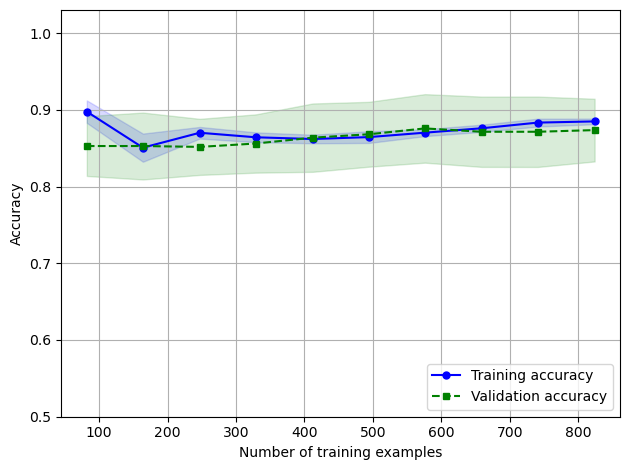

In [74]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rbf_svm,
                               X=train_x,
                               y=train_y,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

## Add a learning curve to Random Forest Model

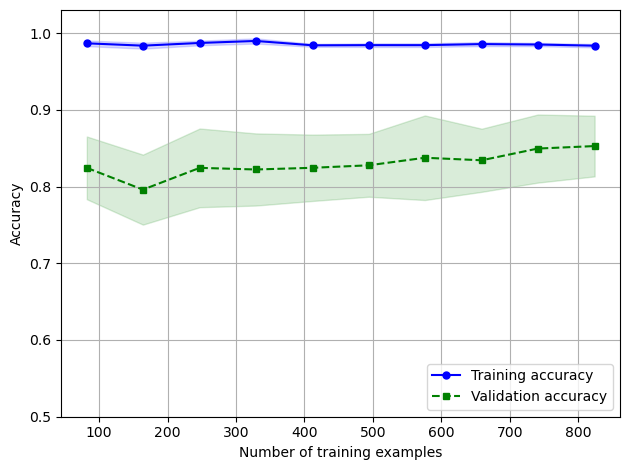

In [73]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rnd_clf,
                               X=train_x,
                               y=train_y,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

## Tuning hyperparameters via RandomGrid search

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

In [62]:
rs = rs.fit(train_x, train_y)
print(rs.best_score_)
print(rs.best_params_)

0.8625895843287148
{'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 0.1}


D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Alternate RandomGrid method

In [63]:
from scipy.stats import uniform
# Can reduce overfitting by lowering the C range and running again
param_grid = param_distributions = [
            {'C': uniform(0.01, 4.0),
             'gamma': uniform(0.01, 0.2)
            }
            ]

svc = SVC(kernel='rbf')

# Defines limit of 5 models (n_inter), each ran 5 times (CV) for 25 total
svc_search = RandomizedSearchCV(svc, param_distributions=param_grid,
                                n_iter=500, cv=5, scoring='accuracy', random_state=13,n_jobs=-1)

svc_search.fit(train_x, train_y)

# Show results from random grid search above
cvres = svc_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8679555713946305 {'C': 3.1208096422952805, 'gamma': 0.05750824400698246}
0.8657816583511524 {'C': 3.307114130645474, 'gamma': 0.20314983960859997}
0.8734141126158234 {'C': 3.900404455619573, 'gamma': 0.10068984948346243}
0.8745010691375624 {'C': 2.4461698510451115, 'gamma': 0.16510530292096937}
0.8755939653124258 {'C': 2.5764533790362765, 'gamma': 0.15440364590338945}
0.8646828225231646 {'C': 0.15014609640574927, 'gamma': 0.06968989417783587}
0.8668686148728912 {'C': 0.244049967528299, 'gamma': 0.1814121885174398}
0.8712342599192209 {'C': 1.50141611149923, 'gamma': 0.1459695903156194}
0.8679555713946305 {'C': 1.0351197973065205, 'gamma': 0.0795162430304984}
0.8614041339985745 {'C': 0.04765108032387765, 'gamma': 0.08166675654099395}
0.8690484675694939 {'C': 3.806376726712841, 'gamma': 0.053579801826337786}
0.8712342599192207 {'C': 1.2875654655214583, 'gamma': 0.1935544772001175}
0.8614100736516989 {'C': 0.13761466575957892, 'gamma': 0.0230169074085029}
0.873408172962699 {'C': 2.529315

D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
svc_search.best_params_

{'C': 2.5764533790362765, 'gamma': 0.15440364590338945}

In [65]:
svc_search.best_estimator_

SVC(C=2.5764533790362765, gamma=0.15440364590338945)

In [66]:
final_model = svc_search.best_estimator_
test_predictions = final_model.predict(test_x)
#Test accuracy
accuracy_score(test_y, test_predictions)

0.8549618320610687

## Test hyperparameters using BayesSearch on RandomForest Model

In [67]:
#pip install scikit-optimize

In [68]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 10),
    # Add more parameters here if needed
}

rnd_clf = RandomForestClassifier(n_jobs=-1)

bayes_search = BayesSearchCV(
    estimator=rnd_clf,
    search_spaces=param_grid,
    n_iter=32,  # Number of iterations (parameter settings sampled)
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

bayes_search.fit(train_x, train_y)

print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)

best_model = bayes_search.best_estimator_

Best parameters found:  OrderedDict([('max_depth', 7), ('min_samples_split', 6), ('n_estimators', 54)])
Best score achieved:  0.8744955176970607


D:\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [69]:
test_predictions = best_model.predict(test_x)
#Test accuracy
accuracy_score(test_y, test_predictions)

0.8549618320610687

## Test hyperparameters using BayesSearch on SVC Model

In [79]:
from skopt import BayesSearchCV
from skopt.space import Real

param_grid = param_distributions = [
            {'C': Real(0.01, 4.0),
             'gamma': Real(0.01, 0.2)
            }
            ]

svc = SVC(kernel='rbf')

bayes_search = BayesSearchCV(
    estimator=svc,
    search_spaces=param_grid,
    n_iter=32,  # Number of iterations (parameter settings sampled)
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

bayes_search.fit(train_x, train_y)

print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)

best_model = bayes_search.best_estimator_

Best parameters found:  OrderedDict([('C', 3.883996508718599), ('gamma', 0.07210237169746278)])
Best score achieved:  0.8712132576163434


D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
test_predictions = best_model.predict(test_x)
#Test accuracy
accuracy_score(test_y, test_predictions)

0.8498727735368957

In [81]:
import pickle
filename = 'bestSVC.sav'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

In [83]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=best_model,
                             X=train_x,
                             y=train_y,
                             cv=10,
                             scoring='accuracy', 
                             n_jobs=-1)  # Utilizing all available CPU cores

print(f'CV Accuracy scores: {scores}')
print(f'CV Accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV Accuracy scores: [0.80434783 0.84782609 0.86956522 0.89130435 0.81521739 0.86956522
 0.87912088 0.9010989  0.96703297 0.84615385]
CV Accuracy: 0.869 +/- 0.044


## Apply unsupervised learning with Kmeans clustering

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#clstrdf = df.drop(['Survived'], axis=1)
clstrdf = df

In [26]:
clstrdf = preprocessor.fit_transform(clstrdf)
clstrdf.shape

(1309, 13)

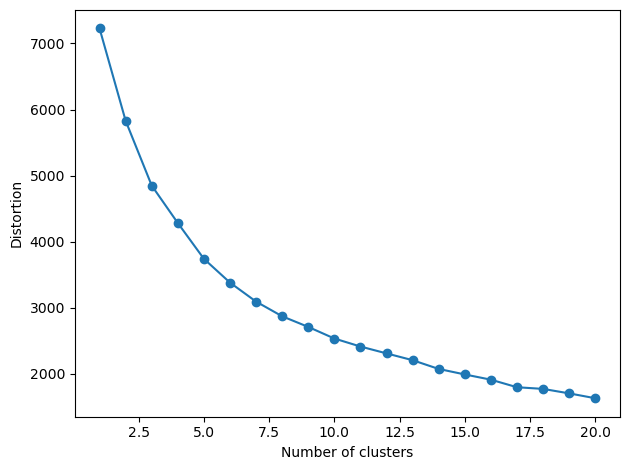

In [27]:
distortions = []
for i in range(1, 21):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(clstrdf)
    distortions.append(km.inertia_)
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('figures/km-elbow.png', dpi=300)
plt.show()

In [37]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, tol=1e-04, random_state=42)
clusters = kmeans.fit_predict(clstrdf)

In [38]:
# Add the cluster labels to the dataframe
df['Cluster'] = clusters

# Analyze cluster counts
print(df['Cluster'].value_counts())

# Explore characteristics of each cluster
print(df.groupby('Cluster').mean())


0    1095
1     214
Name: Cluster, dtype: int64
         Survived    Pclass        Age    SibSp     Parch       Fare
Cluster                                                             
0        0.343379  2.282192  31.913014  0.26210  0.095890  26.803778
1        0.551402  2.359813  19.630467  1.71028  1.864486  66.525000


C:\Users\chadu\AppData\Local\Temp\ipykernel_23968\1633692764.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby('Cluster').mean())


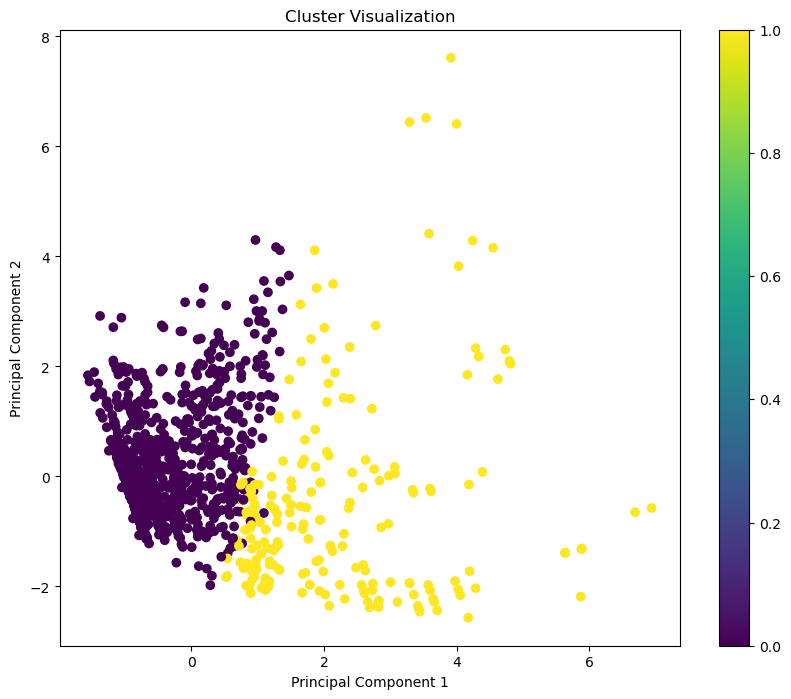

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(clstrdf)
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.colorbar()
plt.show()

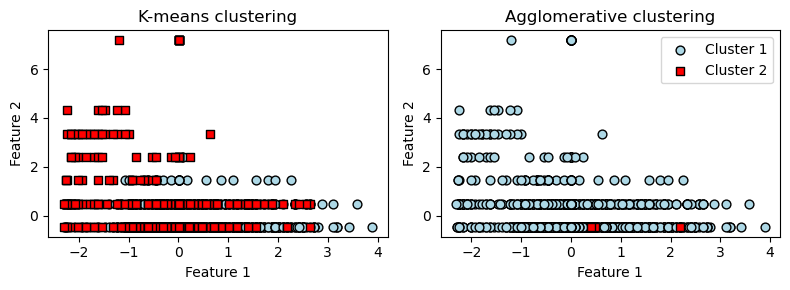

In [43]:
from sklearn.cluster import AgglomerativeClustering

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(clstrdf)
ax1.scatter(clstrdf[y_km == 0, 0], clstrdf[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(clstrdf[y_km == 1, 0], clstrdf[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(clstrdf)
ax2.scatter(clstrdf[y_ac == 0, 0], clstrdf[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(clstrdf[y_ac == 1, 0], clstrdf[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.legend()
plt.tight_layout()
#plt.savefig('figures/10_15.png', dpi=300)
plt.show()